In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Libraries

In [2]:
# Essentials and data wrangling libraries
import numpy as np
import pandas as pd
import datetime
import random

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline 

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data

In [3]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
display(train.head(5))
display(test.head(5))

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [5]:
display(train.shape)
display(test.shape)

(1460, 81)

(1459, 80)

# EDA

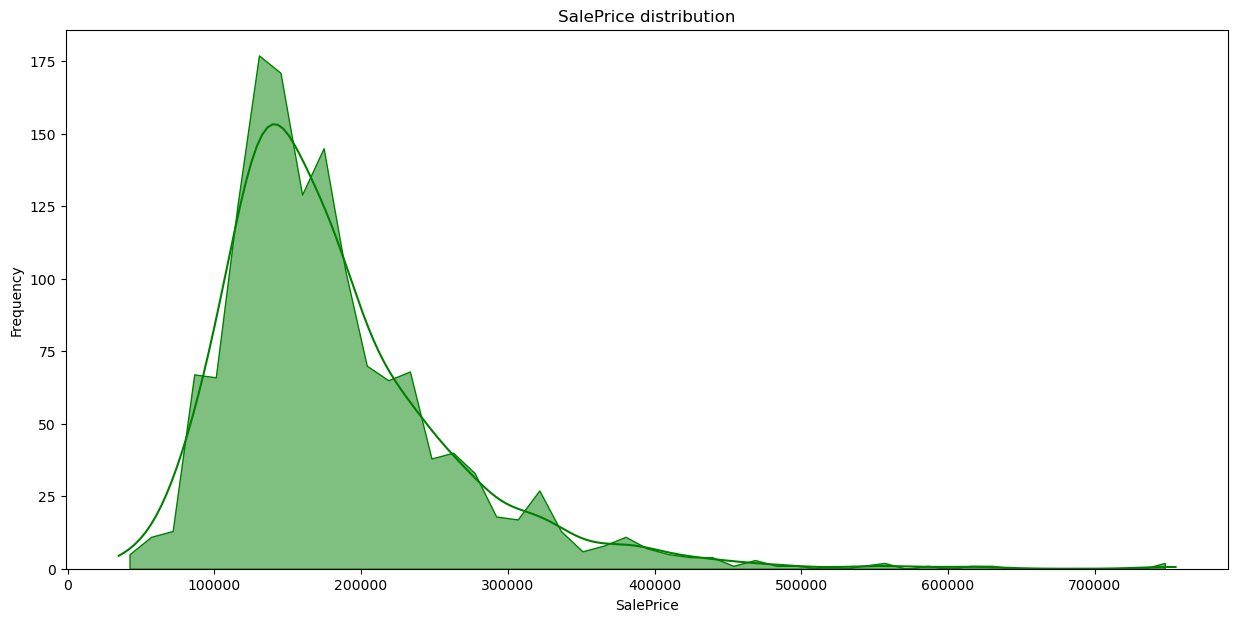

In [6]:
fig, ax = plt.subplots(figsize=(15,7))
sns.histplot(data=train, x=train['SalePrice'], kde=True, element='poly', color='green')
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")

plt.show()

In [7]:
print('skew:', train['SalePrice'].skew())
print('kurt:', train['SalePrice'].kurt())                     

skew: 1.8828757597682129
kurt: 6.536281860064529


In [8]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
        if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf',
                 'haspool','hasgarage','hasbsmt','hasfireplace']:
            pass
        else:
            numeric.append(i)

## Plotting SalePrice vs numeric features

In [9]:
print(len(list(numeric)))

38


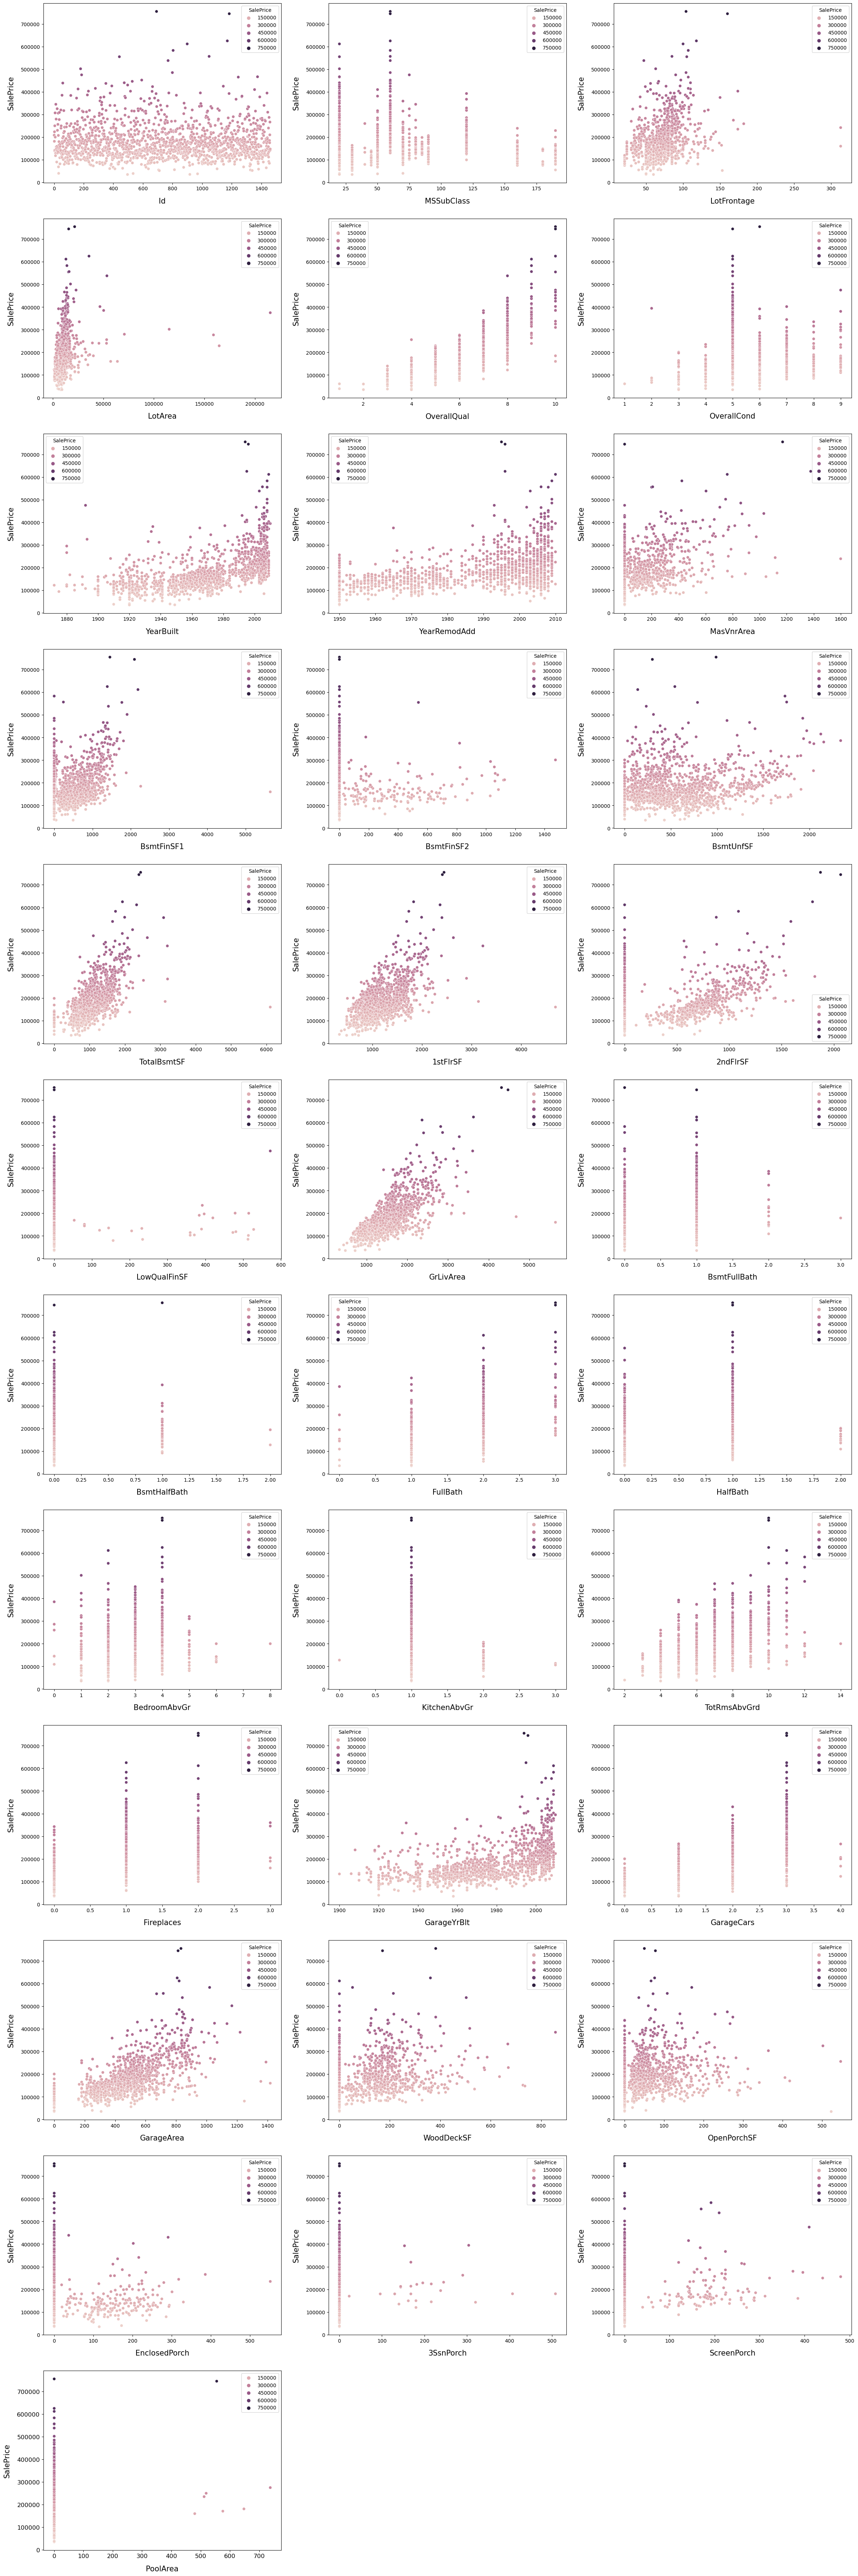

In [10]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize=(12,120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)

for i, feature in enumerate(list(train[numeric]), 1):
    if(feature=='MiscVal'):
        break
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', data=train)
    
    plt.xlabel('{}'.format(feature), size=15, labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
for j in range(2):
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size':10})
    
plt.show()

## Correlation Matrix

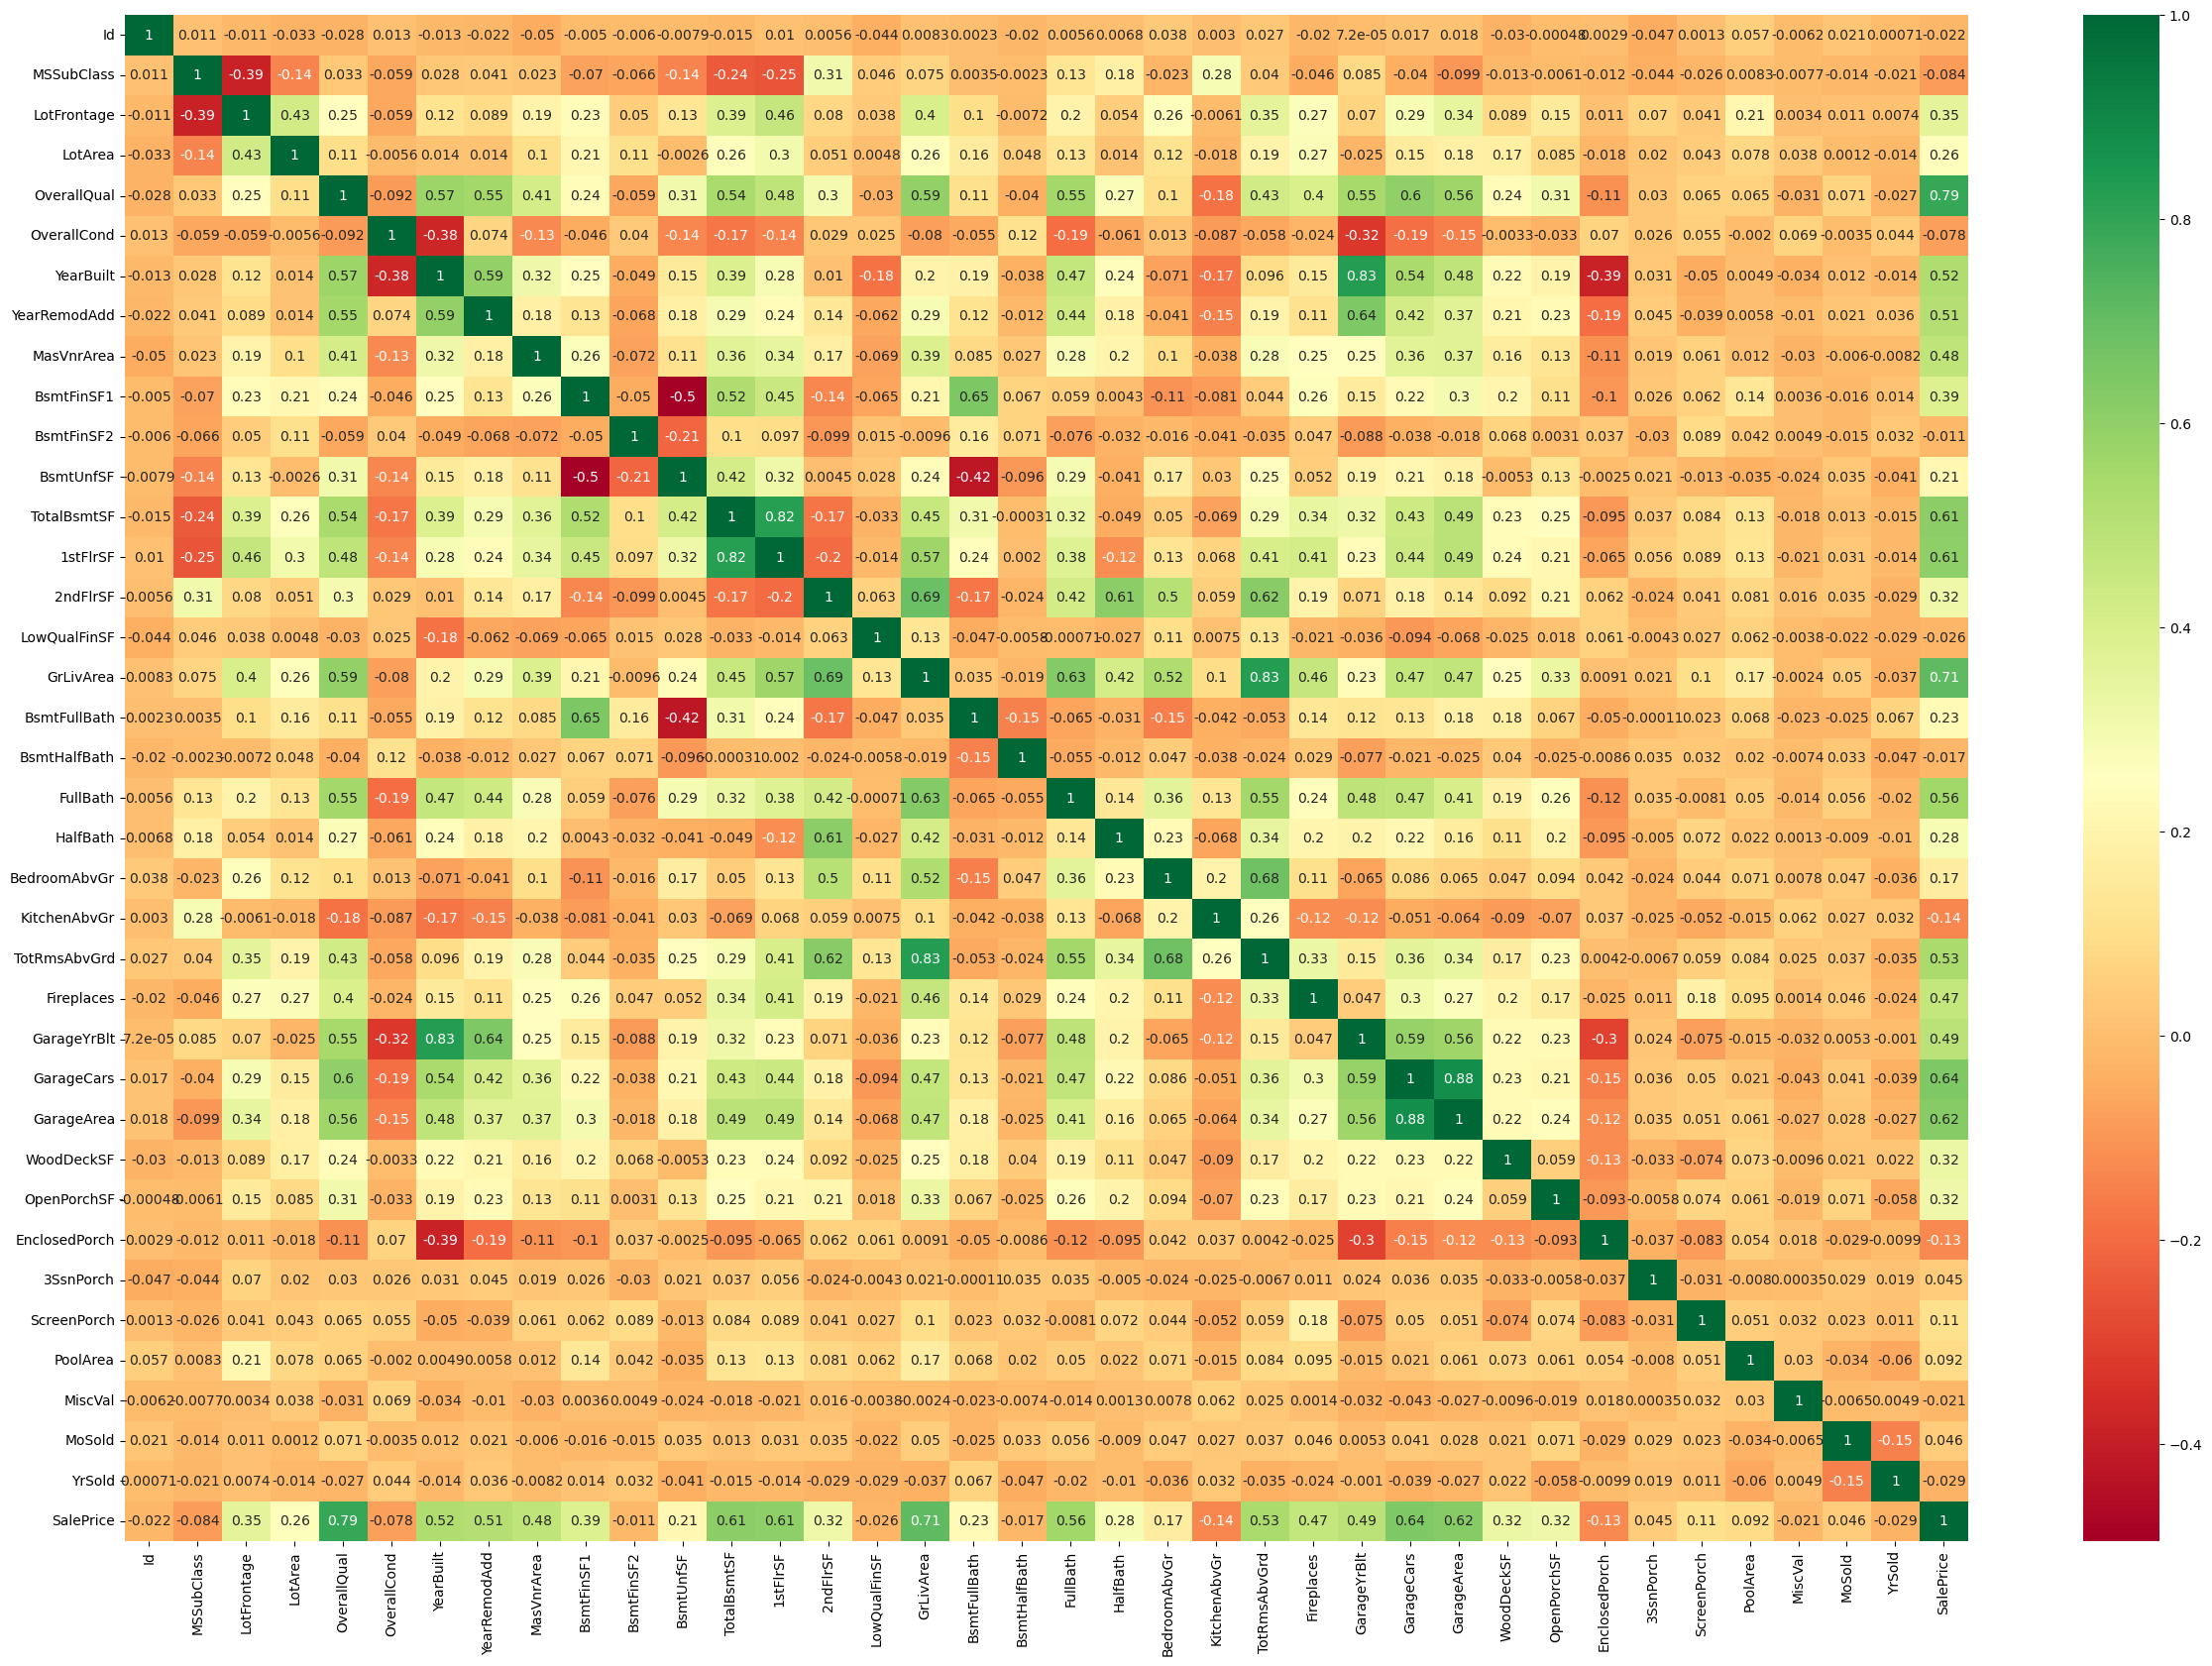

In [11]:
corr = train.corr()
fig, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr, annot=True, cmap="RdYlGn")
plt.show()

## Extracting most correlated features

In [12]:
print('Highly correlated features')
corr['SalePrice'].sort_values(ascending=False)[:10]

Highly correlated features


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

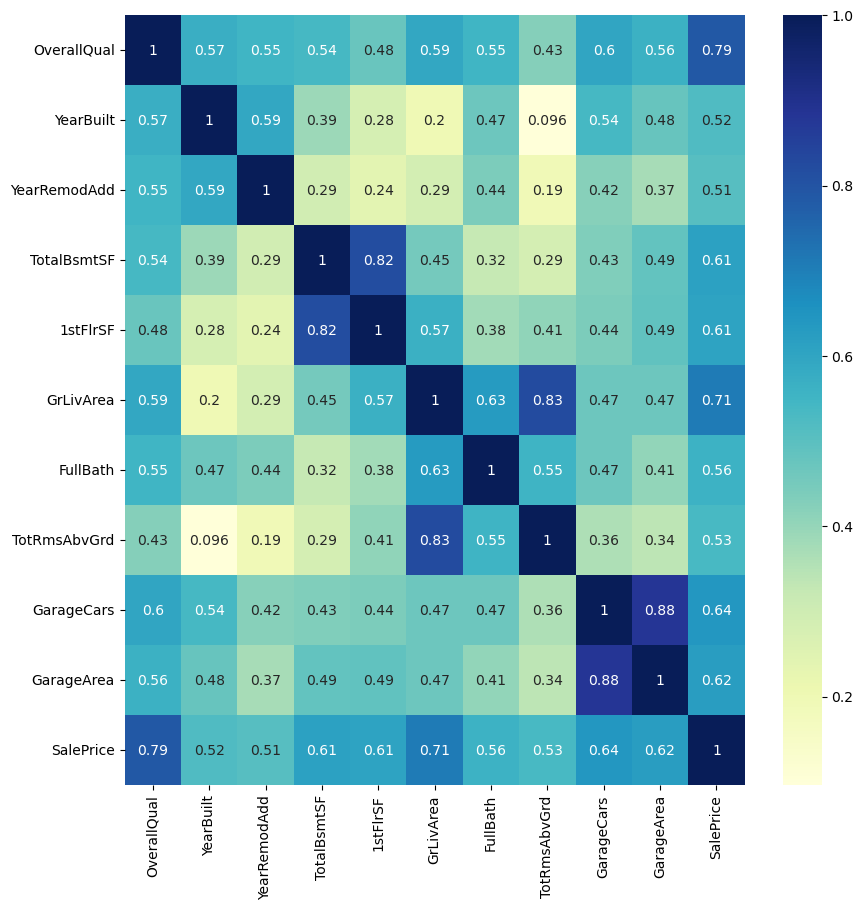

In [13]:
top_corr_features = corr.index[abs(corr['SalePrice']) > 0.5]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(train[top_corr_features].corr(), annot=True, cmap='YlGnBu')
plt.show()

## Sales price vs Overall Quality

In [14]:
import plotly.express as px
fig = px.box(train, x='OverallQual', y='SalePrice',
             color='OverallQual', title="Sales price vs Overall Quality")
fig.add_trace(go.Box(
    marker_color='#FF851B'
))
fig

## Sales price vs YearBuilt

In [15]:
fig = px.box(train, x='YearBuilt', y='SalePrice', color='YearBuilt')
fig

## Sales price vs GrLivArea

In [16]:
fig = px.scatter(train, x='GrLivArea', y='SalePrice', color='GrLivArea',
                size='GrLivArea', marginal_x='histogram')
fig.show()

## Sales price vs TotalBsmtSF

In [17]:
fig = px.scatter(train, x='TotalBsmtSF', y='SalePrice', color='TotalBsmtSF',
                size='TotalBsmtSF', marginal_x='histogram')
fig.show()

## Sales price vs LotArea

In [18]:
fig = px.scatter(train, x='LotArea', y='SalePrice', color='LotArea',
                 size='LotArea', marginal_x='histogram')
fig.show()

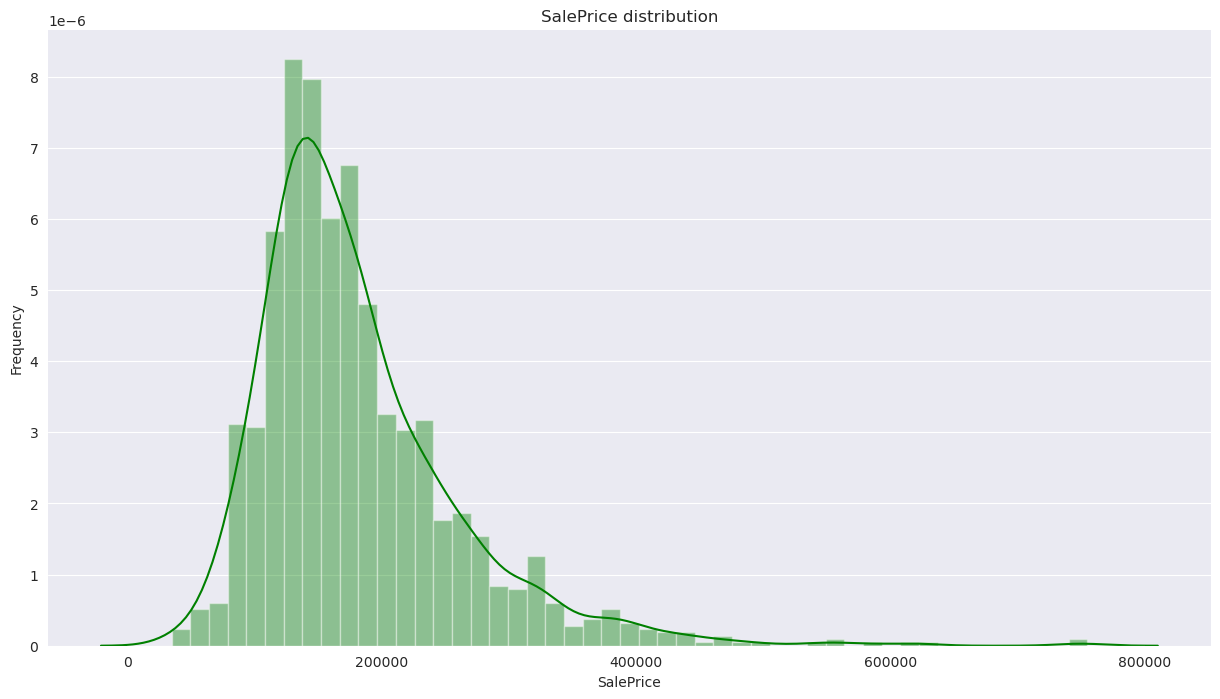

In [19]:
sns.set_style('darkgrid')
sns.set_color_codes(palette='deep')
fig, ax = plt.subplots(figsize=(15, 8))
#Check the distribution
sns.distplot(train['SalePrice'], color='green')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')
sns.despine(trim=True, left=True)
plt.show()

## log(l+x) transform

In [20]:
train['SalePrice'] = np.log1p(train['SalePrice'])

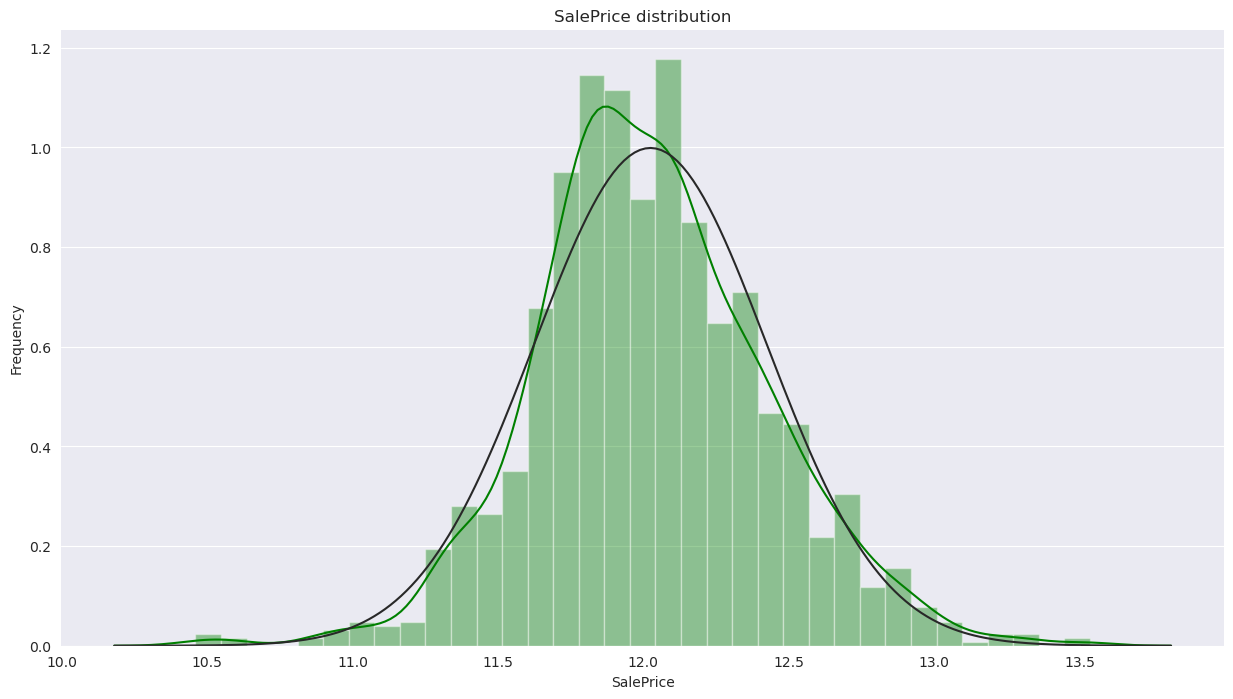

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.set_style('darkgrid')
sns.set_color_codes(palette='deep')
#Check the new distribution;
sns.distplot(train['SalePrice'], fit=norm, color='green')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='SalePrice')
ax.set(title='SalePrice distribution')
sns.despine(trim=True, left=True)
plt.show()

In [22]:
(mu, sigma) = norm.fit(train['SalePrice'])
print('mu:', mu.round(2))
print('sigma:', sigma.round(2))

mu: 12.02
sigma: 0.4


## Missing value percentage by feature

In [23]:
missing = (train.isnull().mean() * 100).sort_values(ascending=False)[:10]
missing

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
dtype: float64

In [24]:
type(missing)

pandas.core.series.Series

In [25]:
fig = px.bar(missing, x=missing.index, y=missing.values, color=missing.index,
            text=missing.values.round(2), title='Percent missing data by feature')
fig.update_traces(width=0.4)
fig.update_layout(xaxis_title='Features',
                 yaxis_title='Percent of missing values',
                 font = dict(size=17))
fig.show()

In [26]:
train.shape

(1460, 81)

In [27]:
X = train.drop(['Id', 'SalePrice'], axis=1)
y = train['SalePrice']

X_test = test.drop(['Id'], axis=1)

X.shape, y.shape, X_test.shape

((1460, 79), (1460,), (1459, 79))

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=40)
    # train_test_split으로 데이터를 훈련세트와 검증세트로 분할
    # test_size는 전체 데이터의 0.2를 test_data로 사용한다는 의미
    # random_state는 데이터를 무작위로 섞을 때 고정되게 하는 값
    # X는 입력변수, y는 종속변수를 나타냄
    # train데이터에서 훈련세트와 검증세트로 나뉘고, test데이터는 X_test로 따로 있음에 유의

# Feature Engineering

## Get numerical and categorical features

In [29]:
numeric_feats = X.dtypes[X.dtypes != 'object'].index
categoric_feats = X.dtypes[X.dtypes == 'object'].index

In [30]:
na_numeric_feats = [k for k, v in X[numeric_feats].isnull().sum().to_dict().items() if v > 0]
                        # dict.items()는 딕셔너리의 키와 밸류를 짝지어 반환한다. for문에서 활용이 용이
na_categoric_feats = [k for k, v in X[categoric_feats].isnull().sum().to_dict().items() if v > 0]

print(na_numeric_feats)
print(na_categoric_feats)

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


## Clean numerical and categorical features with missing values

In [31]:
imp = SimpleImputer(strategy='mean')
type(imp.fit_transform(X_train[na_numeric_feats]))

numpy.ndarray

In [32]:
imp = SimpleImputer(strategy='mean')
    # SimpleImputer 클래스 생성 후, 결측치를 해당 열의 평균으로 대체하는 mean전략 채택
X_train[na_numeric_feats] = imp.fit_transform(X_train[na_numeric_feats])
    # X_train[na_numeric_feats]의 결측치들을 평균값으로 대체하여 X_train[na_numeric_feats]에 할당
X_val[na_numeric_feats] = imp.transform(X_val[na_numeric_feats])
X_test[na_numeric_feats] = imp.transform(X_test[na_numeric_feats])
    # fit_transform 메서드로 train데이터를 기준으로 데이터 변환을 위한 기준을 세운 뒤 결측치를 대체한다.
    # train데이터로 fit이 적용된 기준상태에서 transform 메서드로 결측치를 대체함으로써 모델의 일반화를 한다.

for feat in na_categoric_feats:
    X_train[feat].fillna('Missing', inplace=True)
    X_val[feat].fillna('Missing', inplace=True)
    X_test[feat].fillna("Missing", inplace=True)
        # 범주형 데이터는 평균으로 대체가 어려우므로 Missing문자열로 대체

## Scale numerical features

In [34]:
for feat in numeric_feats:
    scaler = RobustScaler()
        # RobustScaler는 데이터의 중앙값과 IQR을 사용하여 스케일링하여 이상치에 강함
    X_train[feat] = scaler.fit_transform(X_train[feat].values.reshape(-1, 1))
        # values.reshape(-1, 1)는 series나 df을 2차원 numpy array로 변환
    X_val[feat] = scaler.transform(X_val[feat].values.reshape(-1, 1))
    X_test[feat] = scaler.transform(X_test[feat].values.reshape(-1, 1))

## Encode categorical features

In [35]:
for feat in categoric_feats:
    encoder = OrdinalEncoder()
    X_train[feat] = encoder.fit_transform(X_train[feat].values.reshape(-1, 1))
    X_val[feat] = encoder.fit_transform(X_val[feat].values.reshape(-1, 1))
        # 의문점 : 왜 여기서도 fit_transform을 사용할까

## Log-transformation of skewed target variable

In [36]:
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
    # y = train[SalePrice]이였고 이를 train_test_split을 해준 것이 y_train, y_val이므로 여기에도 로그함수 적용

## Function to calculate metric results

In [39]:
def calculate_results(y_true, y_pred):
        # 회귀 모델의 성능평가에 쓰이는 함수(회귀 모델의 평가는 R^2가 중요) 
    model_mae = mean_absolute_error(y_val, y_pred)
    model_mse = mean_squared_error(y_val, y_pred)
    model_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    model_r2 = r2_score(y_val, y_pred)
        # 모델에서 종속 변수의 분산 비율 1에 가까워야 좋음
    model_rmsle = np.log(np.sqrt(mean_squared_error(y_val, y_pred)))
    
    model_results = {"Mean Absolute Error (MAE)": model_mae,
                     "Mean Squared Error (MSE)": model_mse,
                     "Root Mean Squared Error (RMSE)": model_rmse,
                     "Adjusted R^2 Score": model_r2,
                     "Root Mean Squared Log Error": model_rmsle}
    return model_results

# Modeling

## Gradient Boosting Regressor

In [42]:
gbr = GradientBoostingRegressor(n_estimators=6000,
                               learning_rate=0.01,
                               max_depth=4,
                               max_features='sqrt',
                               min_samples_leaf=15,
                               min_samples_split=10,
                               loss='huber',
                               random_state=42)
    # 여러 개의 하이퍼 파라미터를 설정하여 Gradient Boosting 회귀 모델을 생성하여 gbr에 할당
    # n_estimators는 트리의 개수, learning_rate는 학습률, max_depth는 각 트리의 최대 깊이를 의미

#xgboost.fit(X_train. y_train)
y_pred = gbr.fit(X_train, y_train).predict(X_val)
    # 생성한 모델에 fit()메서드를 실행해 훈련 데이터에 대해 학습시킨다.
    # 학습시킨 상태에서 predict메서드로 검증 데이터인 X_val에 대해 예측을 수행한 값을 y_pred에 할당한다.
    # 이 과정에서 모델의 학습과 예측값 생성이 이루어진다.
gbr_results = calculate_results(y_val, y_pred)
    # 검증 데이터인 y_val와 모델에서 도출한 예측값인 y_pred를 성능평가함수에 넣어 다양한 평가지표를 gbr_results에 할당
pd.DataFrame(gbr_results, index=['values']).T
    # 행 인덱스를 values로 지정하여 df생성

values
Mean Absolute Error (MAE)       0.006842
Mean Squared Error (MSE)        0.000085
Root Mean Squared Error (RMSE)  0.009206
Adjusted R^2 Score              0.901082
Root Mean Squared Log Error    -4.687913

## Light Gradient Boosting Regressor

In [43]:
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

y_pred = lightgbm.fit(X_train, y_train).predict(X_val)
lightgbm_results = calculate_results(y_val, y_pred)
pd.DataFrame(lightgbm_results, index=['values']).T

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


values
Mean Absolute Error (MAE)       0.007068
Mean Squared Error (MSE)        0.000093
Root Mean Squared Error (RMSE)  0.009652
Adjusted R^2 Score              0.891269
Root Mean Squared Log Error    -4.640617

## Random Forest Regressor

In [49]:
rf = RandomForestRegressor()
y_pred = rf.fit(X_train, y_train).predict(X_val)
rf_results = calculate_results(y_val, y_pred)
pd.DataFrame(rf_results, index=['values']).T

values
Mean Absolute Error (MAE)       0.006904
Mean Squared Error (MSE)        0.000099
Root Mean Squared Error (RMSE)  0.009960
Adjusted R^2 Score              0.884223
Root Mean Squared Log Error    -4.609227

In [50]:
results = {"Random_forest": rf_results,
           "GBR":gbr_results,
           "lightBGM": lightgbm_results
          }

In [51]:
pd.DataFrame(results).T

Mean Absolute Error (MAE)  Mean Squared Error (MSE)  \
Random_forest                   0.006904                  0.000099   
GBR                             0.006842                  0.000085   
lightBGM                        0.007068                  0.000093   

               Root Mean Squared Error (RMSE)  Adjusted R^2 Score  \
Random_forest                        0.009960            0.884223   
GBR                                  0.009206            0.901082   
lightBGM                             0.009652            0.891269   

               Root Mean Squared Log Error  
Random_forest                    -4.609227  
GBR                              -4.687913  
lightBGM                         -4.640617